### Loading data

In [ ]:
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
# Mounting colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Stanfard Car Dataset directory
base_path = '/content/drive/My Drive/301_Project/Datasets/Stanfard_Car_Datasets'
base_path = './data'
# Train and test images dataset path
cars_train_path = f'{base_path}/cars_train'
cars_test_path = f'{base_path}/cars_test'
# Annotations mat file path
annotations_path = f'{base_path}/cars_annos.mat'
annotations_train_path = f'{base_path}/cars_train_annos.mat'
annotations_test_path = f'{base_path}/cars_test_annos.mat'

In [ ]:
train_mat = scipy.io.loadmat(annotations_train_path)
train_annotations = train_mat['annotations'][0]

test_mat = scipy.io.loadmat(annotations_test_path)
test_annotations = test_mat['annotations'][0]

training_image_label_dictionary = {}

for annotation in train_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    training_image_label_dictionary[filename] = label

testing_image_label_dictionary = {}

for annotation in test_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    testing_image_label_dictionary[filename] = label

class_names = [i[0] for i in scipy.io.loadmat(annotations_path)['class_names'][0]]
print(f'There are {len(class_names)} classes in the dataset')

There are 196 classes in the dataset


In [ ]:
class StanfordCarsDataset(Dataset):
    def __init__(self, directory, image_label_dict, transform=None):
        self.directory = directory
        self.image_label_dict = image_label_dict
        self.transform = transform
        self.images = list(image_label_dict.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(image_path).convert('RGB')
        label = self.image_label_dict[self.images[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(), # Flip the image horizontally with a 50% chance
        # transforms.RandomRotation(20), # Rotate image by 20 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# initialize your datasets
train_dataset = StanfordCarsDataset(cars_train_path, training_image_label_dictionary, train_transforms)
test_dataset = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary, test_transforms)

## Load the previously pretrained ViT and predict the Psuedo Label

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vit_b_16, ViT_B_16_Weights


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    all_predictions = []
    all_confidence = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_scores = nn.functional.softmax(outputs, dim=1)
            confidence = torch.max(softmax_scores, 1).values
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            all_predictions.extend(preds.cpu().numpy())
            all_confidence.extend(confidence.cpu().numpy())
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset), all_predictions, all_confidence


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to unfreeze layers


def unfreeze_layers(model, num_unfreeze_layers):
    for param in model.parameters():
        param.requires_grad = False
    encoder_layers = model.vit.encoder.layers
    num_blocks = len(encoder_layers)
    blocks_to_unfreeze = num_blocks - num_unfreeze_layers
    for i in range(blocks_to_unfreeze, num_blocks):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True


# ViT Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)


# Best hyperparameters
batch_size = 48
learning_rate = 0.00084
num_unfreeze_layers = 4
epochs = 100  # increase epochs for final training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ViTModel(num_classes=len(class_names)).to(device)

# Unfreeze layers
unfreeze_layers(model, num_unfreeze_layers)

# load the best model
Vit_path = './Vit_path.pth'
model.load_state_dict(torch.load(Vit_path))

# evaluate the accuracy of the model
loss_fn = nn.CrossEntropyLoss()
test_loss, test_acc, test_predictions, test_confidence = evaluate(model, test_loader, loss_fn, device)

# iterate over the test dataset and show the label
all_labels = []
for i, (inputs, labels) in enumerate(test_loader):
    all_labels.extend(labels.cpu().numpy())

# compare with the test predictions
print(f'Test Accuracy: {sum([1 for i, j in zip(all_labels, test_predictions) if i == j]) / len(all_labels)}')

100%|██████████| 168/168 [00:13<00:00, 12.78it/s]


Test Accuracy: 0.8058699166770302


### Basic visualization of the results

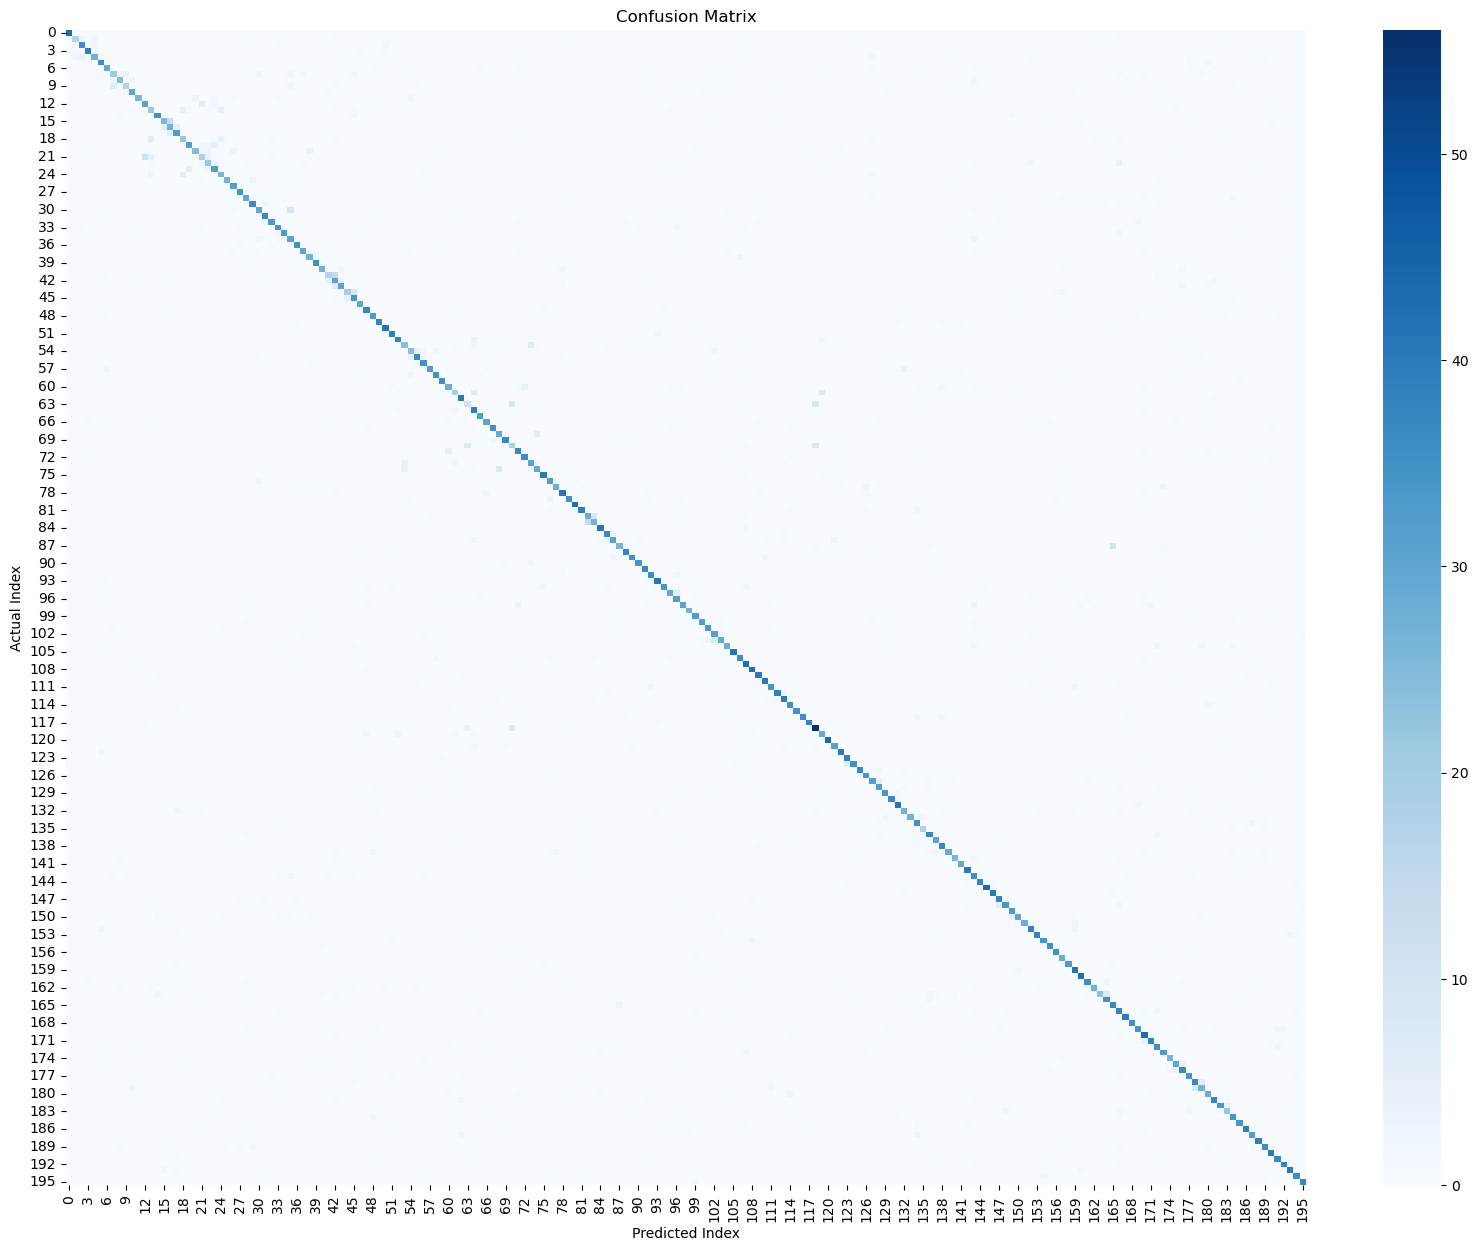

In [ ]:
# visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, test_predictions)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.xlabel('Predicted Index')
plt.ylabel('Actual Index')
plt.title('Confusion Matrix')
plt.show()


### Distribution of the confidence

Based on the observation, we can see that the most of the confidence scores are above 0.9. This is a good sign that the model is confident about the predictions.

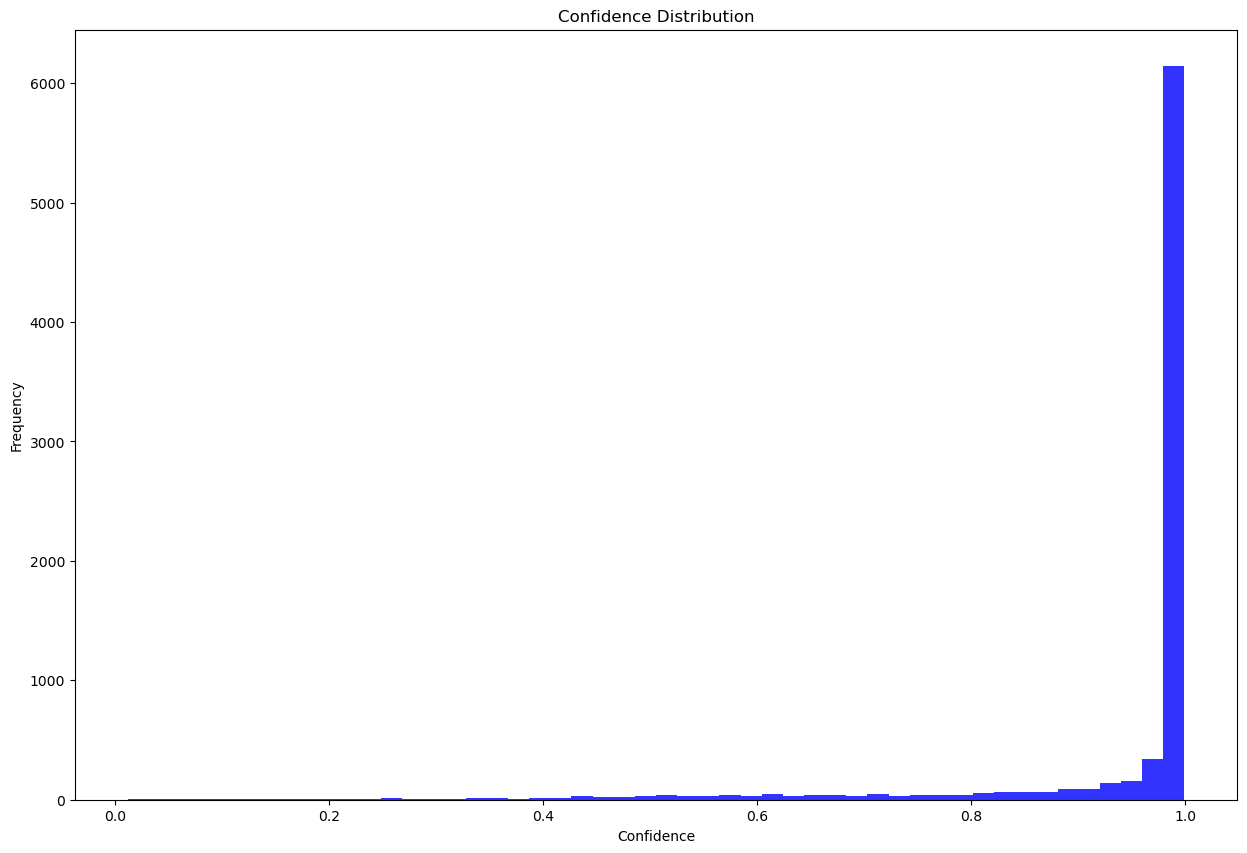

In [ ]:
# visualize the confidence of the model
plt.figure(figsize=(15, 10))
plt.hist(test_confidence, bins=50, color='blue', alpha=0.8)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.show()

### Combine the Pseudo Labels with the original dataset

We set the threshold of accepting the pseudo labels to be 0.99. This means that we only accept the predictions that have a confidence score above 0.99. This is to ensure that the model is confident about the predictions.

In [ ]:
train_mat = scipy.io.loadmat(annotations_train_path)
train_annotations = train_mat['annotations'][0]

training_image_label_dictionary = {}

for annotation in train_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    training_image_label_dictionary[filename] = label

test_mat = scipy.io.loadmat(annotations_test_path)
test_annotations = test_mat['annotations'][0]

testing_image_label_dictionary_pseudo = {}
threshold = 0.99

for i, annotation in enumerate(test_annotations):
    filename = annotation[-1][0]
    label = test_predictions[i]
    if test_confidence[i] > threshold:
        testing_image_label_dictionary_pseudo[filename] = label

train_dataset_raw = StanfordCarsDataset(cars_train_path, training_image_label_dictionary, train_transforms)
test_dataset_pseudo = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary_pseudo, train_transforms)

# combine them
train_dataset = torch.utils.data.ConcatDataset([train_dataset_raw, test_dataset_pseudo])

test_mat = scipy.io.loadmat(annotations_test_path)
test_annotations = test_mat['annotations'][0]

testing_image_label_dictionary = {}

for annotation in test_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    testing_image_label_dictionary[filename] = label

test_dataset = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary, test_transforms)

# show the dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Pseudo Test dataset size: {len(test_dataset_pseudo)}')
# the ratio of the pseudo test dataset
print(f'Pseudo Test dataset ratio: {len(test_dataset_pseudo) / len(test_dataset) * 100:.2f}%')

Training dataset size: 13850
Pseudo Test dataset size: 5706
Test dataset size: 8041
Pseudo Test dataset ratio: 70.96%


### Then we can compute the accuracy of the filtered pseudo labels

After filtering the labels with a threshold of 0.99, the accuracy of the pseudo labels reaches 93.02%. And the total number of pseudo labels is 5706, which is about 70% of the original test set.

In [ ]:
# compute the overall accuracy on the test set and the pseudo test set
acc_test = sum([1 for i, j in zip(all_labels, test_predictions) if i == j]) / len(all_labels)
print(f'Overall Accuracy on the Test Set: {acc_test * 100:.2f}%')
# get the index based on threshold
test_confidence = np.array(test_confidence)
selected_index = test_confidence > threshold
# get the pseudo test labels
pseudo_test_labels = [test_predictions[i] for i in range(len(test_predictions)) if selected_index[i]]
# get the actual test labels
actual_test_labels = [all_labels[i] for i in range(len(all_labels)) if selected_index[i]]
# compute the accuracy of the pseudo test set
acc_pseudo_test = sum([1 for i, j in zip(actual_test_labels, pseudo_test_labels) if i == j]) / len(actual_test_labels)
print(f'Overall Accuracy on the Pseudo Test Set: {acc_pseudo_test * 100:.2f}%')

Overall Accuracy on the Test Set: 80.59%
Overall Accuracy on the Pseudo Test Set: 93.02%


### Extract the features from the last layer of the pretrained model

In [ ]:
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

batch_size = 32
train_loader_raw = DataLoader(train_dataset_raw, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader_pseudo = DataLoader(test_dataset_pseudo, batch_size=batch_size, shuffle=False, num_workers=8)

def extract_features_and_label_sources(model, loader, device, source_label):
    features = []
    labels = []
    sources = []
    model.eval()
    with torch.no_grad():
        for images, lbls in tqdm(loader):
            images = images.to(device)
            feature = model.vit(images) # extract features from the last layer of the model
            features.append(feature.cpu().detach())
            labels.extend(lbls.cpu().detach().numpy())
            sources.extend([source_label] * images.size(0))
    features = torch.cat(features, dim=0)
    return features, labels, sources


train_features_raw, train_labels_raw, train_sources = extract_features_and_label_sources(model, train_loader_raw, device, 'Train')
test_features_pseudo, test_labels_pseudo, test_sources = extract_features_and_label_sources(model, test_loader_pseudo, device, 'Pseudo-Test')

# combine the features and labels
combined_features = torch.cat([train_features_raw, test_features_pseudo], dim=0)
combined_labels = np.concatenate([train_labels_raw, test_labels_pseudo], axis=0)
combined_sources = np.array(train_sources + test_sources)

  0%|          | 1/255 [00:00<02:40,  1.58it/s]

100%|██████████| 179/179 [00:08<00:00, 21.25it/s]


### Visualize the pseudo labels

#### We can observe that most of the pseudo labels on the test set aligns well with the training dataset, which is a good sign that the pseudo labels are reliable.

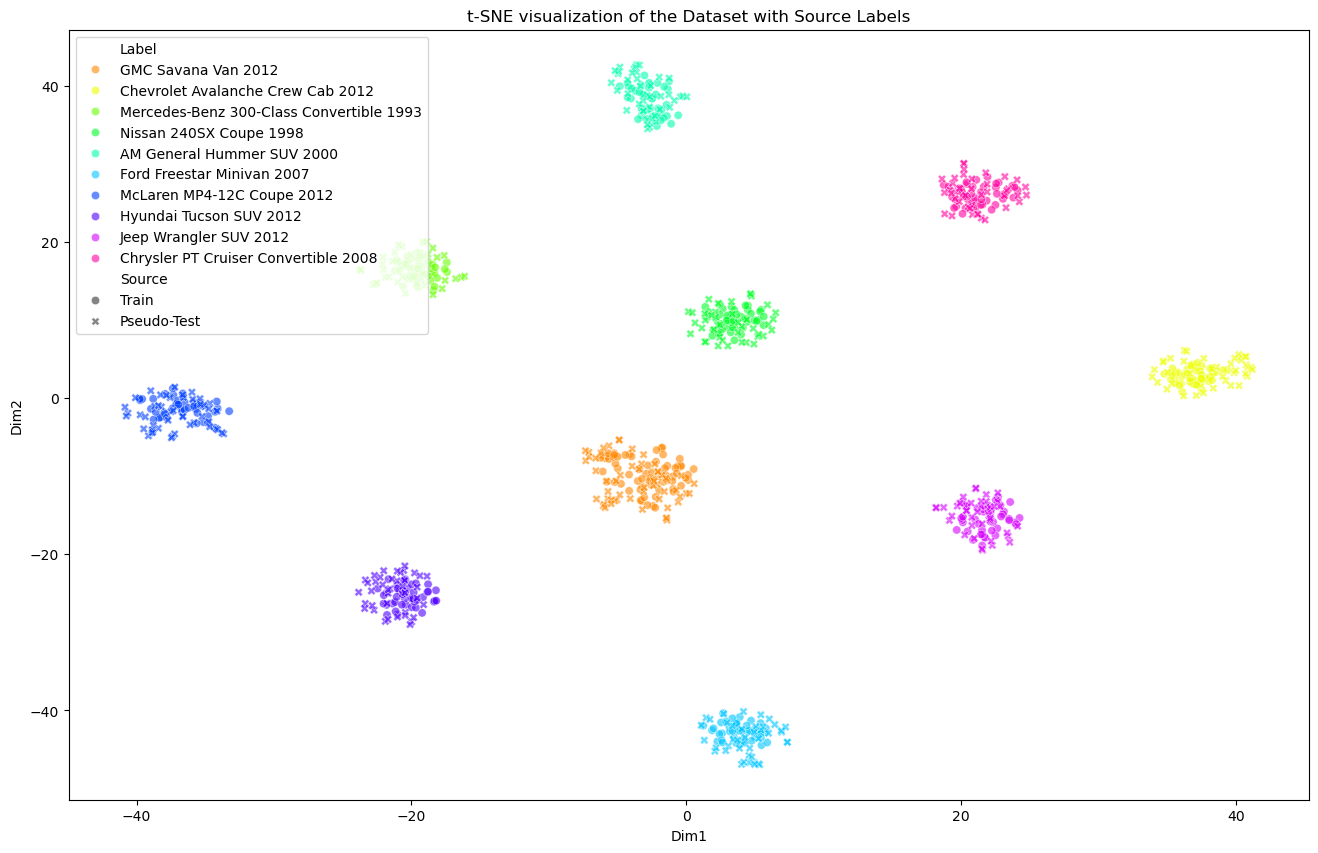

In [ ]:
# filter the top classes
max_classes = 10
unique, counts = np.unique(combined_labels, return_counts=True)
top_classes = unique[np.argsort(-counts)[:max_classes]]
mask = np.isin(combined_labels, top_classes)
filtered_features = combined_features[mask]
filtered_labels = combined_labels[mask]
filtered_sources = combined_sources[mask]

# reduce the dimensionality of the features
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(filtered_features.numpy())

df = pd.DataFrame(reduced_features, columns=['Dim1', 'Dim2'])
df['Label'] = [class_names[l] for l in filtered_labels] # convert the labels to class names
df['Source'] = filtered_sources

plt.figure(figsize=(16, 10))
sns.scatterplot(x='Dim1', y='Dim2', hue='Label', style='Source', palette=sns.color_palette("hsv", max_classes), data=df, legend='full', alpha=0.6)
plt.title('t-SNE visualization of the Dataset with Source Labels')
plt.show()

### Visualization without the threshold

In contrast, if we visualize the pseudo labels without the threshold, we can see that the pseudo labels are not as reliable as the previous one. There exists much noise in the pseudo labels if we do not set a threshold.

100%|██████████| 252/252 [00:11<00:00, 21.32it/s]


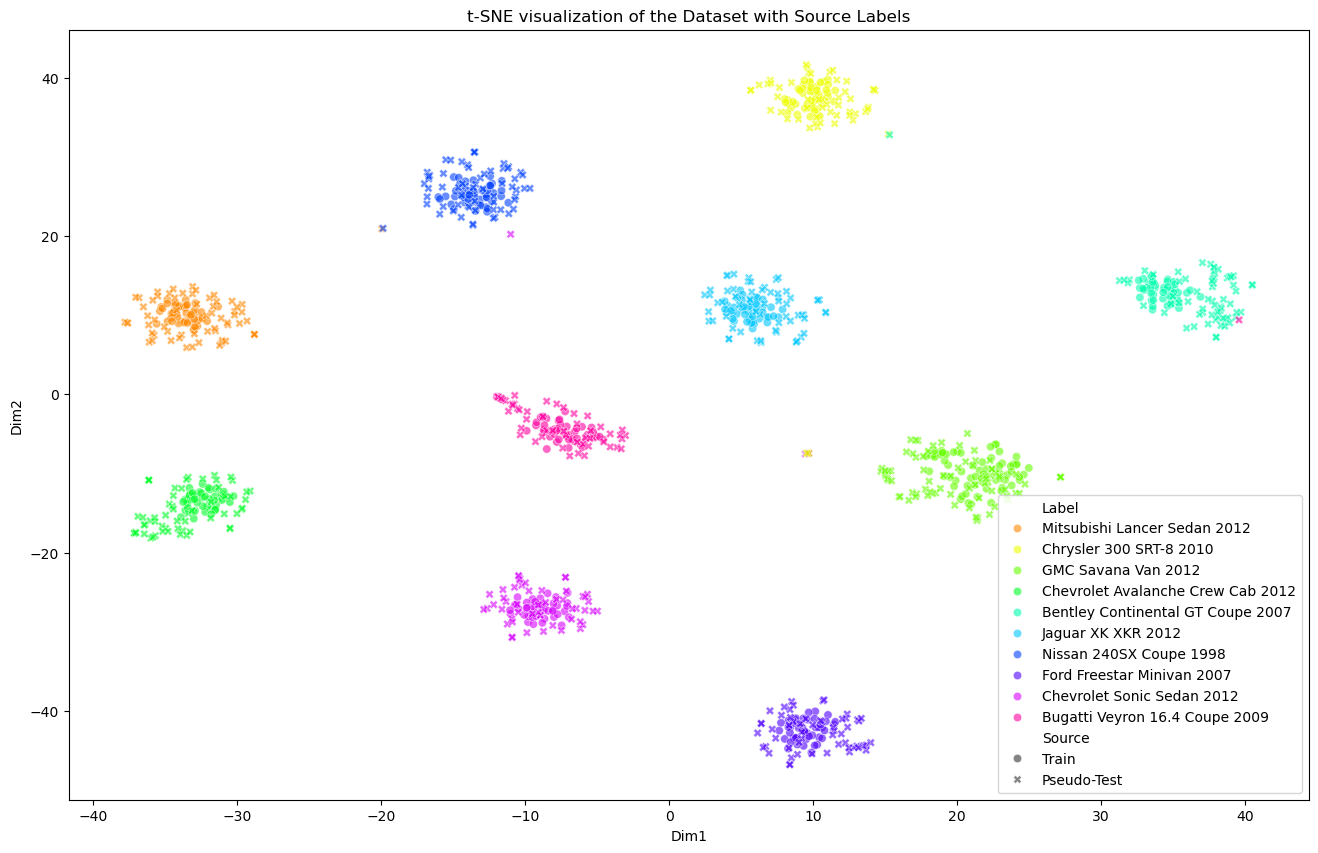

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import matplotlib.pyplot as plt
test_mat = scipy.io.loadmat(annotations_test_path)
test_annotations = test_mat['annotations'][0]

testing_image_label_dictionary_pseudo_no_threshold = {}
threshold = 0

for i, annotation in enumerate(test_annotations):
    filename = annotation[-1][0]
    label = test_predictions[i]
    if test_confidence[i] > threshold:
        testing_image_label_dictionary_pseudo_no_threshold[filename] = label

test_dataset_pseudo_no_threshold = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary_pseudo_no_threshold, train_transforms)


batch_size = 32
train_loader_raw = DataLoader(train_dataset_raw, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader_pseudo_no_threshold = DataLoader(test_dataset_pseudo_no_threshold, batch_size=batch_size, shuffle=False, num_workers=8)


def extract_features_and_label_sources(model, loader, device, source_label):
    features = []
    labels = []
    sources = []
    model.eval()
    with torch.no_grad():
        for images, lbls in tqdm(loader):
            images = images.to(device)
            feature = model.vit(images)  # extract features from the last layer of the model
            features.append(feature.cpu().detach())
            labels.extend(lbls.cpu().detach().numpy())
            sources.extend([source_label] * images.size(0))
    features = torch.cat(features, dim=0)
    return features, labels, sources


test_features_pseudo, test_labels_pseudo, test_sources = extract_features_and_label_sources(model, test_loader_pseudo_no_threshold, device, 'Pseudo-Test')

# combine the features and labels
combined_features = torch.cat([train_features_raw, test_features_pseudo], dim=0)
combined_labels = np.concatenate([train_labels_raw, test_labels_pseudo], axis=0)
combined_sources = np.array(train_sources + test_sources)

# filter the top classes
max_classes = 10
unique, counts = np.unique(combined_labels, return_counts=True)
top_classes = unique[np.argsort(-counts)[:max_classes]]
mask = np.isin(combined_labels, top_classes)
filtered_features = combined_features[mask]
filtered_labels = combined_labels[mask]
filtered_sources = combined_sources[mask]

# reduce the dimensionality of the features
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(filtered_features.numpy())

df = pd.DataFrame(reduced_features, columns=['Dim1', 'Dim2'])
df['Label'] = [class_names[l] for l in filtered_labels]  # convert the labels to class names
df['Source'] = filtered_sources

plt.figure(figsize=(16, 10))
sns.scatterplot(x='Dim1', y='Dim2', hue='Label', style='Source', palette=sns.color_palette("hsv", max_classes), data=df, legend='full', alpha=0.6)
plt.title('t-SNE visualization of the Dataset with Source Labels')
plt.show()

### Saving the new dataset

In [ ]:
train_dataset_raw = StanfordCarsDataset(cars_train_path, training_image_label_dictionary, train_transforms)
test_dataset_pseudo = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary_pseudo, train_transforms)
test_dataset = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary, test_transforms)
test_dataset_pseudo_no_threshold = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary_pseudo_no_threshold, train_transforms)

# Define the path in Google Drive where the datasets will be stored
drive_path = '/content/drive/My Drive/301_Project/Datasets/dataset_new'

# Check if the path exists, if not, create it
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# Save them to the drive
torch.save(train_dataset_raw, f'{drive_path}/train_dataset_raw.pth')
torch.save(test_dataset_pseudo, f'{drive_path}/test_dataset_pseudo.pth')
torch.save(test_dataset, f'{drive_path}/test_dataset.pth')
torch.save(test_dataset_pseudo_no_threshold, f'{drive_path}/test_dataset_pseudo_no_threshold.pth')